# COVID-19 data

- Notes of patients with the diagnosis `COVID-19, virus geïdentificeerd \[U07.1]`.
- The data is from 2020 and Q1 of 2021.
- The data is from the two locations of the Amsterdam UMC: `amc` and `vumc`.

In [1]:
import pandas as pd

import sys
sys.path.insert(0, '..')
from utils.latex import show_latex
from utils.config import PATHS

# Load data

To see how the `covid_data.pkl` file was created, see `covid_data_prep.ipynb`.

In [2]:
datapath = PATHS.getpath('data_covid')
df = pd.read_pickle(datapath / 'covid_data.pkl')

df.Notitiedatum = pd.to_datetime(df.Notitiedatum)

In [3]:
domains=['ADM', 'ATT', 'BER', 'ENR', 'ETN', 'FAC', 'INS', 'MBW', 'STM']
levels = [f"{domain}_lvl" for domain in domains]

# Number of patients and notes

Overview of the data:
- Number of patients ('MDN')
- Number of notes ('NotitieID'); the notes are divided into annotated and not annotated

In [4]:
df.pivot_table(
    index=['institution'],
    columns=['annotated'],
    values=['NotitieID', 'MDN'],
    aggfunc={'MDN': 'nunique', 'NotitieID': 'count'},
    margins=True,
    margins_name='Total',
).iloc[:,2:].pipe(show_latex, caption='na', label='na')

MDN NotitieID                
annotated    Total     False   True    Total
institution                                 
amc            719    60,678  1,314   61,992
vumc           577    47,722  1,067   48,789
Total        1,290   108,400  2,381  110,781

# Labels

Number of notes with labels.
- For annotated==True, the labels are gold labels from annotations
- For annotated==False, the labels are predictions generated by the ML models

In [5]:
df_any_lvl = df.assign(any_lvl = df[levels].any(axis=1))
totals = df_any_lvl.groupby('annotated').any_lvl.sum().rename('Total notes with label(s)')
totals['Total'] = df_any_lvl.any_lvl.sum()

table = df.pivot_table(
    index = 'annotated',
    values = levels,
    aggfunc = 'count',
).T
table['Total'] = table.sum(axis=1)
table = table.append(totals)
table.pipe(show_latex, caption='na', label='na')

annotated,False,True,Total
ADM_lvl,"53,320","1,613","54,933"
ATT_lvl,939,97,"1,036"
BER_lvl,"1,973",71,"2,044"
ENR_lvl,"8,481",415,"8,896"
ETN_lvl,"24,089",829,"24,918"
FAC_lvl,"12,771",352,"13,123"
INS_lvl,"7,719",417,"8,136"
MBW_lvl,"3,864",209,"4,073"
STM_lvl,"14,111",377,"14,488"
Total notes with label(s),"69,320","1,760","71,080"


# Notes per patient

<AxesSubplot:>

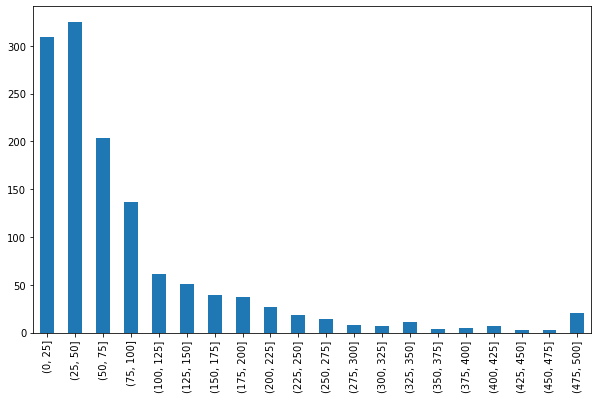

In [6]:
# patients with over 500 notes are counted in the (475, 500] bin

s = df.groupby('MDN').NotitieID.size()
s.loc[lambda s: s > 500] = 500
bins = range(0,525,25)
pd.cut(s, bins=bins).value_counts(sort=False).plot.bar(figsize=(10,6))